# AIRDOS 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import matplotlib.pyplot as plt

In [2]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [3]:
fto = './data/DATALOG.TXT' #  File to Open
l=[]
l.extend(range(0,520))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*')

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

## Plot Flux

In [5]:
date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
altitude = np.nan
LatDD = np.nan
LonDD = np.nan
speed = np.nan
flag=0

for i,r in df.iterrows():
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        flag = 1
        speed = r[7]
        
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.set_value(i,'date',date)
    #df.set_value(i,'altitude',np.nan)
    df.set_value(i,'altitude',altitude)
    df.set_value(i,'speed',speed)

    if (r[0] == '$CANDY'):
        date = date + pd.Timedelta(seconds=14)
        df.set_value(i,'date',date)
        #if (flag==1):
        #    df.set_value(i,'altitude',altitude)
        #    flag=0
        
dfo = df
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)

dfo.to_csv('radiation.csv')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()


TypeError: Empty 'DataFrame': no numeric data to plot

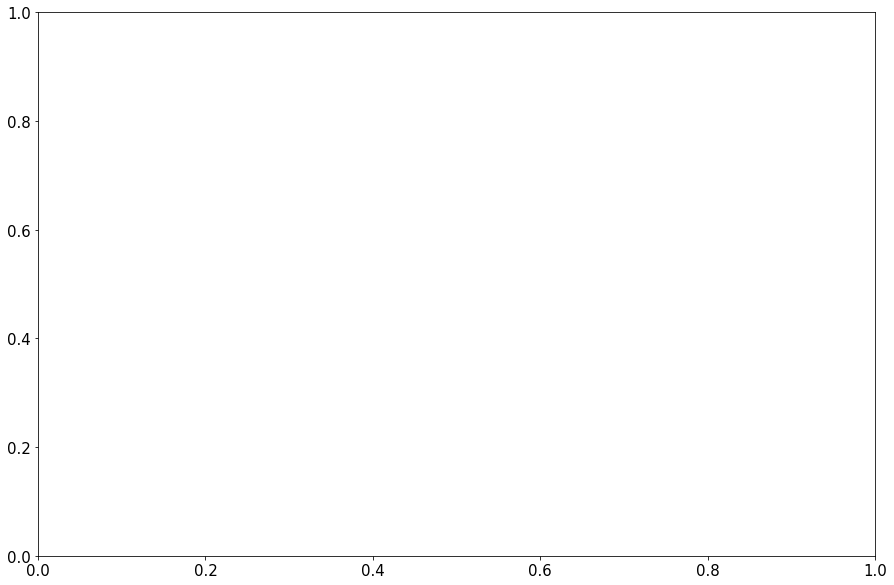

In [7]:
#DeviceName = 'AIRDOS A005'
DeviceName = 'AIRDOS T4'
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
dfo = dfo.dropna(how='any')
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
#xx = dfo.loc['2017-11-29 12:30:00':'2017-11-29 16:00:00']
xx = dfo
#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)

NOISE_LEVEL=261
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
xx['highflux'] = xx[range(NOISE_LEVEL+20,LAST_CHANNEL)].sum(axis=1)
xx[range(NOISE_LEVEL,LAST_CHANNEL)] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].mul(range(1,LAST_CHANNEL+1-NOISE_LEVEL),axis=1)
xx['rad'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

WINDOW = 20
xx['rad'] = pd.rolling_mean(xx['rad'],WINDOW)
xx['flux'] = pd.rolling_mean(xx['flux'],WINDOW)
xx['highflux'] = pd.rolling_mean(xx['highflux'],WINDOW)
#xx['altitude'] = pd.rolling_mean(xx['altitude'],WINDOW)

#xx['rad'].plot(c='r', label='Doserate (rolling mean '+str(WINDOW)+')')
xx['rad'].plot(c='red')
plt.yscale('log')

plt.xlabel('UT')
plt.ylabel('Doserate in Silicon per 10 seconds [arbitrary unit]', color='red')
#, xticks=['2017-03-27 00:00','2017-03-27 12:00','2017-03-28 00:00','2017-03-28 12:00','2017-03-29 00:00'],figsize=(20,5))
plt.legend(loc=2)

ax = plt.twinx()
xx['altitude'].plot(c='b', label='alt', marker='o', linewidth='5', linestyle='None')
plt.ylabel('altitude [m a.s.l.]', color='blue')
#plt.ylim([0,500])
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(DeviceName + ' (rolling mean ' + str(WINDOW) + ')')

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 20})

xx['flux'].plot(c='red')
#plt.ylim([0,15])

plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='1. Ch',zorder=1)
plt.xlabel('UT')
plt.ylabel('Flux per 10 seconds [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()
plt.ylim([11400,11460])
#xx['altitude'].plot(c='b', label='alt', marker='o', linewidth='2', linestyle='none', drawstyle='steps-mid')
xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('altitude [m a.s.l.]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(DeviceName + ' (rolling mean ' + str(WINDOW) + ')')

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 20})
xx['flux'].plot(c='r', xticks=['2017-11-29 12:30','2017-11-29 12:35','2017-11-29 12:40','2017-11-29 12:45','2017-11-29 12:50','2017-11-29 12:55','2017-11-29 13:00','2017-11-29 13:05','2017-11-29 13:10','2017-11-29 13:15','2017-11-29 13:20','2017-11-29 13:25','2017-11-29 13:30','2017-11-29 13:35','2017-11-29 13:40','2017-11-29 13:45','2017-11-29 13:50','2017-11-29 13:55','2017-11-29 14:00','2017-11-29 14:05','2017-11-29 14:10','2017-11-29 14:15','2017-11-29 14:20','2017-11-29 14:25','2017-11-29 14:30','2017-11-29 14:35','2017-11-29 14:40','2017-11-29 14:45','2017-11-29 14:50','2017-11-29 14:55','2017-11-29 15:00'])
plt.ylabel('Flux per 10 seconds [counts]', color='red')
#ax = plt.twinx()
#xx['speed'].plot(c='b')
#plt.ylim([400,700])
#plt.ylabel('speed [kts]', color='blue')
#(xx['highflux']*10).plot()
plt.grid(b=True, which='both', axis='both', color='grey', linestyle='-')


#'''flux to file
xxx = pd.DataFrame()
xxx = xx[['altitude','flux','speed']]
xxx.to_csv('flux.csv')
#'''

In [6]:
rc = df.loc[df[0]=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

#rc.to_csv('ble.txt')

#rc['sum'] = rc[range(24,544)].sum(axis=1)
#rc['sum'] = rc[range(21,544)].sum(axis=1)
#rc['sum']


plt.figure(figsize=(20,5))
plt.ylim([0,5])
NOISE_LEVEL=21
xx = rc.ix[:]
NOISE_LEVEL=260
LAST_CHANNEL=514
#xx[range(NOISE_LEVEL,LAST_CHANNEL)] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].mul(range(1,LAST_CHANNEL+1-NOISE_LEVEL),axis=1)
xx['rad'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

WINDOW = 30
xx['rad'] = pd.rolling_mean(xx['rad'],WINDOW)
xx['rad'].plot(c='b')

plt.title('AIRDOS')
plt.xlabel('measurement No.')
plt.ylabel('Flux [counts per 11 s]')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()


In [77]:
# rc.iloc[:,516:1025]
#dfo.iloc[:,516:1025]
#dfo.reset_index(drop=True, inplace=True)
#dfo.iloc[:,500:]
#xx.iloc[:,260:515]
#dfo[range(260,514)]
#df6
print NOISE_LEVEL
xx.iloc[:,268]
xx[['flux','altitude']]


261


,flux,altitude
date,,
2018-01-03 10:36:14,0.0,2561.4
2018-01-03 10:36:28,0.0,2561.4
2018-01-03 10:36:43,0.0,2818.5
2018-01-03 10:36:57,1.0,2818.5
2018-01-03 10:37:12,1.0,3205.8
2018-01-03 10:37:26,1.0,3205.8
2018-01-03 10:37:41,0.0,3494.1
2018-01-03 10:37:55,1.0,3494.1
2018-01-03 10:38:09,1.0,3808.2


# ------------------------------------------------------------------------------------

## Concatenate RMC and GGA lines to one table

In [34]:
df = df.reset_index(drop=True)
df1 = df.loc[df[0]=='$GPRMC']
df1 = df1.iloc[:,0:12]
df2 = df.iloc[df.loc[df[0]=='$GPRMC'].index+1]
df2 = df2.iloc[:,0:15]
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
df5 = pd.concat([df1,df2], axis=1,  ignore_index=True)
# Convert NMEA time to pandas time
df5[9] = df5[9].astype(str)
df5[1] = df5[1].astype(str)
df5[1] = pd.to_datetime(df5[9]+df5[1], format='%d%m%y%H%M%S.%f',errors='coerce')#.dt.time
#df5=df5.rename(columns = {2:'time'})#
#df5 = df5.iloc[:,0:20]

df5.drop(df5[df5[24]!='M'].index, inplace=True)

df5[21] = pd.to_numeric(df5[21],errors='coerce')

df6 = pd.DataFrame()
df6['time']=df5[1]
df6['altitude'] = df5[21]
df6['Lat'] = df5[3]
df6['Lats'] = df5[4]
df6['Lon'] = df5[5]
df6['Lons'] = df5[6]
df6['time'] = pd.to_datetime(df6.time)
df6.set_index('time', inplace=True)
df6.dropna(axis=0,inplace=True)
df6 = df6[pd.notnull(df6.index)]
df6.to_csv('./data/ble.txt')
#df6.iloc[50:100]

## Convert Grades/Minutes to Grades

In [35]:
df6['Lat'] = df6['Lat'].astype(float)
df6['Lon'] = df6['Lon'].astype(float)

df6['Lats'] = df6['Lats'].str.replace('N','1')
df6['Lats'] = df6['Lats'].str.replace('S','-1')
df6['Lons'] = df6['Lons'].str.replace('E','1')
df6['Lons'] = df6['Lons'].str.replace('W','-1')

df6['LatDD'] = (df6.Lat/100).fillna(0).astype(int)
df6['LatDD'] = df6.LatDD + (df6.Lat - 100.0*df6.LatDD)/60.0
df6['LatDD'] = df6.LatDD * df6['Lats'].astype(float)  


df6['LonDD'] = (df6.Lon/100).fillna(0).astype(int)
df6['LonDD'] = df6.LonDD + (df6.Lon - 100.0*df6.LonDD)/60.0
df6['LonDD'] = df6.LonDD * df6['Lons'].astype(float)  

## Plot Map

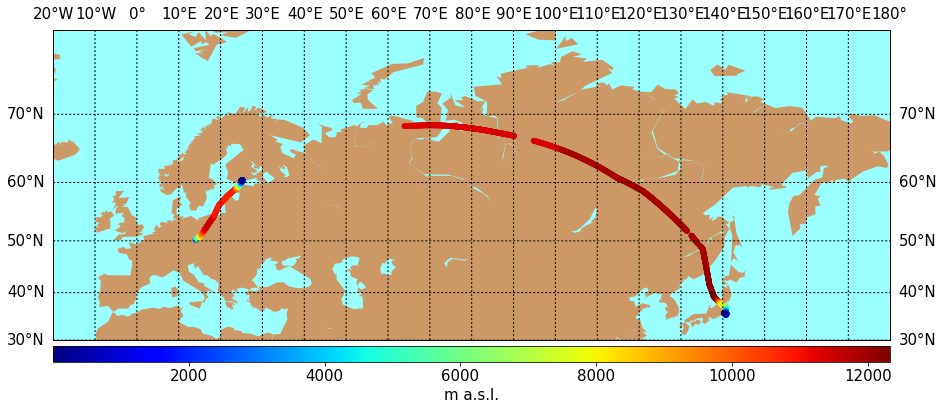

In [38]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

plt.figure(figsize=(15,15))
matplotlib.rcParams.update({'font.size': 15})


# draw map with markers for float locations
#m = Basemap(projection='kav7',lon_0=0)

# World map
m = Basemap(llcrnrlon=-20,llcrnrlat=30,urcrnrlon=180,urcrnrlat=80,projection='mill')

# Detailed map
#m = Basemap(llcrnrlon=14,llcrnrlat=50,urcrnrlon=17,urcrnrlat=51, epsg = 31284,resolution='i',projection='merc')
#m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 800, verbose= True)

x, y = m(df6.LonDD.tolist(),df6.LatDD.tolist())
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
#m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,0])
#m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,1,0])
m.drawparallels(np.arange(-90.,99.,10.),labels=[1,1,0,0])
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,1,0])
#m.scatter(df6.LonDD.tolist(),df6.LatDD.tolist(),3,marker='o',color='r')
im1 = m.scatter(x,y,c=df6.altitude.tolist(),s=7,marker='o',  linewidth='3', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')
plt.show()

In [20]:
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
dfo = dfo.dropna(how='any')
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
xx = dfo.loc['2017-11-10 16:00:00':]
#xx = dfo.loc['2017-11-10 15:20:00':'2017-09-12 09:00:00']
#xx = dfo

NOISE_LEVEL=261
LAST_CHANNEL=513
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
xxx = xx['flux'].resample('5min').sum()

WINDOW = 5
#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
xxx = pd.rolling_mean(xxx,WINDOW)

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 20})

xxx.plot()
plt.ylim([0,20])

plt#.xlabel('UT')
plt.ylabel('Flux [count]', color='red')
#, xticks=['2017-03-27 00:00','2017-03-27 12:00','2017-03-28 00:00','2017-03-28 12:00','2017-03-29 00:00'],figsize=(20,5))
plt.legend(loc=2)


NameError: name 'matplotlib' is not defined